# Table of Contents

- [Preparation](#preparation)
    - [Import Library](#import_library)
    - [Import Data](#import_data)
- [Exploratory Data Analysis and Data Cleaning](#eda_and_clean)
    - [Columns Name](#col_name)
    - [Columns Data Type](#col_data_type)
        - [Kilometres Column](#kilometres_col_dtype)
        - [Doors Column](#doors_col_dtype)
        - [City Column](#city_col_dtype)
        - [Highway Column](#highway_col_dtype)
    - [Turn Other/Donât Know into NaN Values](#other_to_nan)
    - [Check Missing Values](#missing_values)
    - [Data Distribution](#data_distribution)
        - [Categorical Data](#cat_distribution)
            - [Correcting Drivetrain](#correcting_drivetrain)
            - [Correcting FuelType](#correcting_fuel_type)
        - [Numerical Data](#num_distribution)
            - [Descriptive Statistics](#desc_stats)
                - [Drop Invalid Year](#invalid_year)
- [Data Preprocessing](#data_preprocessing)
- [Train Test Split](#train_test_split)

# Preparation <a name='preparation'></a>

## Import Library <a name='import_library'></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from zipfile import ZipFile

## Import Data <a name='import_data'></a>

In [2]:
with ZipFile('used-vehicles-for-sale.zip') as raw_zip:
    raw_zip.extractall(path='datasets')
    
    file_name = raw_zip.namelist()
    
    raw_data = []
    
    for file in file_name:
        try:
            raw_data.append(pd.read_csv(f'datasets/{file}'))
        except UnicodeDecodeError:
            print(f'{file}: Wrong format file')
        
    print(file_name)

In [3]:
raw_data[0].head()

In [4]:
full_data = raw_data[0].iloc[:, 1:]

full_data.head()

# Exploratory Data Analysis and Data Cleaning <a name='eda_and_clean'></a>

## Columns Name <a name='col_name'></a>

In [5]:
full_data.columns

*Warning: Some of column name contains space in the beginning. Hence we will remove it*

In [6]:
full_data.columns = full_data.columns.str.replace(' ', '')

full_data.columns

Columns Information
1. `Year`: The year of the vehicle (year release)
2. `Make`: The make of the vehicle (brand)
3. `Model`: The model of the vehicle
4. `Kilometres`: The distance the vehicle has travelled in Kilometeres
5. `BodyType`: The type of Body the vehicle has
6. `Engine`: Type of Engine in the vehicle
7. `Transmission`: Transmission used in the vehicle
8. `Drivertrain`: Drivetrain configuration of the vehicle
9. `ExteriorColour`: Exterior Colour of the vehicle
10. `InteriorColour`: Interior Colour of the vehicle.
11. `Passengers`: Passengers capacity
12. `Doors`: The number of doors
13. `Fuel Type`: Fuel type of the vehicle
14. `City`: Fuel used per 100 km in city
15. `Highway`: Fuel used per 100 km in highway
16. `Price`: Price of the vehicle in 2023

## Columns Data Type <a name='col_data_type'></a>

In [7]:
full_data.info()

Based on the columns information, `Kilometres`, `Doors`, `City`, and `Highway` should be a numeric data type. Let's inspect it one by one.

### Kilometres Column <a name='kilometres_column_dtype'></a>

In [8]:
full_data['Kilometres']

The problem is the data contains string 'km', hence pandas treat it as object data type. Let's check if all rows contains 'km'.

In [9]:
full_data['Kilometres'].str.contains('km').value_counts()

All rows contains 'km', so we will remove it and then convert the column data type into float.

In [10]:
full_data['Kilometres'] = full_data['Kilometres'].str.replace(' km', '').astype(float)

### Doors Column <a name='doors_column_dtype'></a>

In [11]:
full_data['Doors']

In [12]:
full_data['Doors'].value_counts()

Same as previous column, the problem is there some rows contains string.

In [13]:
full_data['Doors'] = pd.to_numeric(
    full_data['Doors'].str.replace(' doors', ''),
    errors='coerce'
).astype('Int64')

We use `pd.to_numeric` instead of `astype` like the previous one, it's because `pd.to_numeric` can handle invalid input i.e. `Other/Donât Know` and turn them into `NaN` value, after that we use `astype` to convert the data type into `Int64` because it can handle nullable int data.

**Note: Since there are some rows that contains `Other/Donât Know`, we should check other columns, if they contains it or not, and then turn them into `NaN` values.**

### City Column <a name='city_column_dtype'></a>

In [14]:
full_data['City']

In [15]:
full_data['City'].str.contains('100km').value_counts()

It all contains '100km', just in case if some rows contains space, let's remove the space to make sure we can remove 'L/100km'.

In [16]:
city_no_str = full_data['City'].str.replace(' ', '').str.replace('L/100km', '')

city_no_str

In [17]:
city_no_str.value_counts()

It turns out some rows contains '-', let's take the last number and ditch the first number. Here are the steps:
1. We split the string based on '-' and expand it to dataframe, so there will be 2 columns, we store it in variable called `city_split`
2. The rows that doesn't contains '-', their column 1 would be null, hence we use it as `city_mask`
3. We filter the splitted data by `city_mask` and shift the data in column 0 to column 1
4. Finally we only take the column 1 and convert it to float

In [18]:
# step 1
city_split = city_no_str.str.split('-', expand=True)

# step 2
city_mask = city_split[1].isnull()

# step 3
city_split[city_mask] = city_split[city_mask].shift(axis=1)

# step 4
full_data['City'] = city_split[1].astype(float)

### Highway Column <a name='highway_column_dtype'></a>

Since this columns similar to `City` column, we will perform the same steps.

In [19]:
full_data['Highway']

In [20]:
highway_no_str = full_data['Highway'].str.replace(' ', '').str.replace('L/100km', '')

# step 1
highway_split = highway_no_str.str.split('-', expand=True)

# step 2
highway_mask = highway_split[1].isnull()

# step 3
highway_split[highway_mask] = highway_split[highway_mask].shift(axis=1)

# step 4
full_data['Highway'] = highway_split[1].astype(float)

All done! Let's check the data type again

In [21]:
full_data.info()

## Turn `Other/Donât Know` into `NaN` Values <a name='other_to_nan'></a>

We will inspect the columns with the type of `object`.

In [22]:
for column in full_data.select_dtypes(include='object').columns:
    temp_other_sum = full_data.select_dtypes(include='object')[column].str.contains('other', case=False).sum()
    
    print(f'{column} contains {temp_other_sum} "other" values')

Let's turn rows from `FuelType` that contains `Other/Donât Know` into `NaN` values.

In [23]:
mask_fuel_type = full_data['FuelType'].str.contains('other', case=False, na=False)

full_data['FuelType'][mask_fuel_type] = None

## Check Missing Values <a name='missing_values'></a>

In [24]:
print(f'''
Missing values ratio for each columns:

{(full_data.isnull().sum()/len(full_data)).sort_values(ascending=False) }''')

About half rows in `Passengers` column is missing.

In [25]:
full_data = full_data.drop('Passengers', axis=1)

## Data Distribution <a name='data_distribution'></a>

### Categorical Data <a name='cat_distribution'></a>

In [26]:
full_cat_data = full_data.select_dtypes(include='object')

full_cat_data.head()

Before we visualize the data distribution, let's check the unique values for each columns and we only visualize the columns with certain number of unique values.

In [27]:
full_cat_data.nunique()

Let's visualize these columns: `Make`, `BodyType`, `Transmission`, `Drivetrain`, `InteriorColour`, and `FuelType`

In [28]:
for column in ['Make', 'BodyType', 'Transmission', 'Drivetrain', 'InteriorColour', 'FuelType']:
    full_cat_data[column].value_counts().plot(
        kind='bar',
        title=f'{column} Distribution',
        rot=75,
        figsize=(10, 4)
    )
    plt.show()

Some of values from `Drivetrain` and `FuelType` column have same term but different name e.g. in column `FuelType` the value 'Gas', 'Gasoline', 'Gasoline Fuel', and 'Gaseous Fuel Compatible' have same term, which is 'Gasoline'.

In `Transmission` column, we will do some transformation in [Data Preprocessing](#data_preprocessing) section.

#### Correcting Drivetrain <a name='correcting_drivetrain'></a>

In [29]:
full_cat_data['Drivetrain'].unique()

The values '4X4', '4x4', and '4WD' have a same term, which is '4WD'. While '2WD' can be either 'FWD' or 'RWD', so we can't decide it what is the true for it, hence we will convert it to null values. We will map those invalid values to valid values.

In [30]:
drivetrain_map = {
    'AWD': 'AWD',
    'FWD': 'FWD',
    'RWD': 'RWD',
    '4WD': '4WD',
    '4X4': '4WD',
    '4x4': '4WD',
    '2WD': None
}

full_cat_data['Drivetrain'] = full_cat_data['Drivetrain'].map(drivetrain_map)

#### Correcting FuelType <a name='correcting_fuel_type'></a>

In [31]:
full_cat_data['FuelType'].value_counts()

For `FuelType` column let's we rewrite it in mathematical terms, we write a function that mapping those input into valid input:

$ f(x):raw\_input \rightarrow valid\_input $

Where $raw\_input$ is the unique values from `FuelType` column, while $valid\_input = \{'Gasoline',\;'Hybrid',\;'Flexible',\;'Diesel',\;'Electric',\;'Regular\;Unleaded',\;'Premium\;Unleaded'\}$

$ f(x)=   \left\{
\begin{array}{ll}
      'Gasoline' & x \in \{'Gas',\;'Gasoline',\;'Gasoline\;Fuel',\;'Gaseous\;Fuel\;Compatible'\} \\
      'Hybrid' & x \in \{'Gasoline\;Hybrid',\;'Gas/Electric\;Hybrid'\} \\
      'Flexible' & x \in \{'Flexible',\;'E85-\;Gasoline(Flex\;Fuel)'\} \\
      'Diesel' & x \in \{'Diesel'\} \\
      'Electric' & x \in \{'Electric'\} \\
      'Regular\;Unleaded' & x \in \{'Regular\;Unleaded'\} \\
      'Premium\;Unleaded' & x \in \{'Premium\;Unleaded'\} \\
      None & Otherwise
\end{array} 
\right.  $

Let's implement it in the code.

In [32]:
domain_gas = ['Gas', 'Gasoline', 'Gasoline Fuel', 'Gaseous Fuel Compatible']
domain_hybrid = ['Gasoline Hybrid', 'Gas/Electric Hybrid']
domain_flexible = ['Flexible', 'E85- Gasoline(Flex Fuel)']

gas_map = dict.fromkeys(domain_gas, 'Gasoline')
hybrid_map = dict.fromkeys(domain_hybrid, 'Hybrid')
flexible_map = dict.fromkeys(domain_flexible, 'Flexible')

fuel_type_map = {
    **gas_map,
    **hybrid_map,
    **flexible_map,
    'Diesel': 'Diesel',
    'Electric': 'Electric',
    'Regular Unleaded': 'Regular Unleaded',
    'Premium Unleaded': 'Premium Unleaded'
}

full_cat_data['FuelType'] = full_cat_data['FuelType'].map(fuel_type_map)

### Numerical Data <a name='num_distribution'></a>

In [33]:
full_num_data = full_data.select_dtypes(exclude='object')

full_num_data.head()

In [34]:
full_num_data.hist(
    bins=50,
    figsize=(18, 12)
)

plt.show()

There is some outliers in `Kilometres`, `City`, `Highway`, and `Price`, let's remove them

#### Remove Outliers

In [35]:
def detect_outliers(data):
    q_3 = np.nanquantile(data, 0.75)
    q_1 = np.nanquantile(data, 0.25)
        
    inter_q = q_3 - q_1

    upper_bound = q_3 + (1.5*inter_q)
    lower_bound = q_1 - (1.5*inter_q)
    
    return np.logical_or(data < lower_bound, data > upper_bound)

for column in ['Kilometres', 'City', 'Highway', 'Price']:
    full_num_data = full_num_data.drop(
        full_num_data[column][detect_outliers(full_num_data[column])].index,
        errors='ignore'
    )

#### Descriptive Statistics <a name='desc_stats'></a>

In [36]:
full_num_data.describe()

Hold on, the maximum value of `Year` column is 2024, which is exceed current year (2023), we will drop those rows.

##### Drop Invalid `Year` <a name='invalid_year'></a>

In [37]:
mask_year = full_num_data['Year'] > 2023

full_num_data = full_num_data.drop(full_num_data['Year'][mask_year].index).reset_index(drop=True)

#### Correlation

In [38]:
sns.heatmap(
    full_num_data.corr(),
    annot=True,
    vmin=-1,
    vmax=1
)

Before go to the Data Preprocessing section, let's combine the `full_num_data` and `full_cat_data` into one called `full_data`

In [39]:
full_data = pd.concat([full_num_data, full_cat_data.iloc[full_num_data.index, :]], axis=1)

full_data.head()

# Data Preprocessing <a name='data_preprocessing'></a>

## Train Test Split <a name='train_test_split'></a>

In [40]:
from sklearn.model_selection import train_test_split

X = full_data.drop('Price', axis=1)
y = full_data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1
)

In [41]:
X_train_num = X_train.select_dtypes(exclude='object')
X_train_cat = X_train.select_dtypes(include='object')

## Categorical Pipeline

### Transmission Transformation

In [42]:
X_train['Transmission'].unique()

We will transform `Transmission` column into 2 columns called `MainTransmission` which contains $\{'Manual',\;'Automatic',\;'CVT'\}$ and `SpeedTransmission` which contains the number of speed from transmission.

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class TransmissionTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        main_transmission_temp = X['Transmission']
        
        for item in ['manual', 'automatic', 'cvt']:
            index_transmission = X['Transmission'].str.contains(item, case=False, na=False)
            
            main_transmission_temp[index_transmission] = item
            
        speed_transmission = pd.to_numeric(X_train['Transmission'].str.split(expand=True)[0], errors='coerce')
        
        X['MainTransmission'] = main_transmission_temp
        X['SpeedTransmission'] = speed_transmission
        
        return X.drop('Transmission', axis=1)

### Encoding Categorical

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_impute = SimpleImputer(
    strategy='most_frequent'
)

speed_transmission_impute = SimpleImputer(
    strategy='constant',
    fill_value=0
)

one_hot_enc = OneHotEncoder(
    handle_unknown='ignore',
    min_frequency=0.001
)

cat_enc_pipeline = make_pipeline(
    categorical_impute,
    one_hot_enc
)

cat_columns = ['Make', 'Model', 'BodyType', 'Engine', 'Drivetrain', 'ExteriorColour',
               'InteriorColour', 'FuelType', 'MainTransmission']

impute_and_encode = ColumnTransformer([
    ('EncodingCategorical', cat_enc_pipeline, cat_columns),
    ('SpeedTransmissionImpute', speed_transmission_impute, ['SpeedTransmission'])
])

cat_pipeline = make_pipeline(
    TransmissionTransform(),
    impute_and_encode
)

cat_pipeline

### Categorical Feature Selection

In [45]:
from sklearn.feature_selection import SelectKBest, f_regression

cat_feature_select = SelectKBest(
    f_regression,
    k=50
)

select_cat_pipeline = make_pipeline(
    cat_pipeline,
    cat_feature_select
)

select_cat_pipeline

## Numerical Pipeline

### Impute

Note: since there is feature with integer data type, i.e. `Doors`, we will impute it with `strategy='most_frequent'`.

In [46]:
from sklearn.impute import SimpleImputer

num_impute = ColumnTransformer([
    ('impute_num', SimpleImputer(strategy='median'), ['Year', 'Kilometres', 'City', 'Highway']),
    ('impute_doors', SimpleImputer(strategy='most_frequent'), ['Doors'])
])

num_impute

### Scale

In [47]:
num_pipeline = make_pipeline(
    num_impute,
    StandardScaler()
)

num_pipeline

## Full Pipeline

In [48]:
full_pipeline = ColumnTransformer([
    ('numerical_pipeline', num_pipeline, X_train_num.columns),
    ('cat_pipeline', select_cat_pipeline, X_train_cat.columns)
])

full_pipeline

## Data Transformation

In [49]:
full_pipeline.fit(X_train, y_train)

In [50]:
X_train_trans = full_pipeline.transform(X_train).toarray()
X_test_trans = full_pipeline.transform(X_test).toarray()

y_train_trans = np.array(y_train)
y_test_trans = np.array(y_test)

In [51]:
full_train = np.concatenate([X_train_trans, y_train_trans], axis=1)

# Modeling

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train_trans, y_train_trans)

/home/alfian/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor()

RMSE: 10673.842465079844


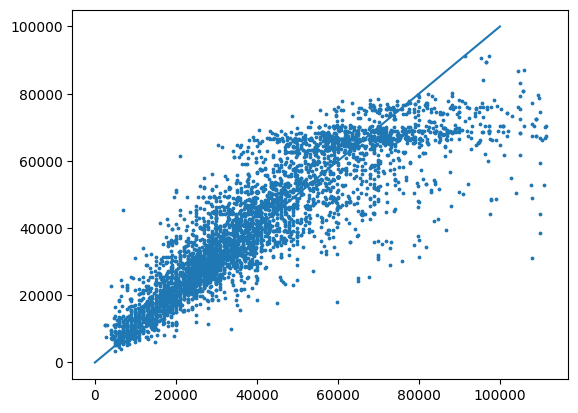

In [64]:
from sklearn.metrics import mean_squared_error

gb_predict = gb_model.predict(X_test_trans)

mse = mean_squared_error(y_test_trans, gb_predict)

plt.scatter(y_test_trans, gb_predict, s=3)
plt.plot([0, 100000], [0, 100000])

print(f'RMSE: {np.sqrt(mse)}')

plt.show()